In [1]:
TRAIN_DIR = "../data/data_sym/ingredients_split/train"
!ls $TRAIN_DIR

allspice	      cocoa_powder	   lemons	    salmon
apples		      coconut		   lettuce	    salsa
artichoke	      confectioners_sugar  limes	    salt
avocado		      cornstarch	   mango	    semisweet_chocolate
background	      cucumber		   margarine	    sesame_oil
bacon		      dill		   mayonnaise	    sesame_seeds
baking_soda	      dressing		   milk		    shallot
bananas		      eggplant		   mint_leaves	    shortening
basil		      eggs		   miso_paste	    shrimp
beans		      fish_sauce	   mixed_nuts	    soy_sauce
bell_pepper	      flour		   molasses	    spaghetti_sauce
black_olives	      garlic		   mushrooms	    spinach
black_pepper	      garlic_powder	   mustard	    steak
bok_choy	      garlic_salt	   noodle	    strawberries
bread		      ginger		   oil		    sugar
broccoli	      grapes		   onion	    syrup
broth_carton	      green_beans	   onion_powder     thyme_spice
brown_sugar	      green_onions	   oranges	    tofu
butter		      ground_beef	   oregano	    tomatoes
cabbage		      ground_cinnamo

In [2]:
import os
from glob import glob

import numpy as np
from PIL import Image
from keras.utils import Sequence
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


class CIFAR10Sequence(Sequence):
    def __init__(
        self, directory_of_train_or_val, batch_size, augmentations, width, height
    ):
        # Here, self.x is list of path to the images
        # and self.y are the associated classes.
        image_paths = list()
        y_class_names = list()
        for root, dirs, files in os.walk(directory_of_train_or_val, topdown=False):
            for name in dirs:
                # subdirectory paths: ex: path to apple folder
                y_class_path = os.path.join(root, name)
                glob_train_imgs = os.path.join(y_class_path, "*")
                class_img_paths = glob(glob_train_imgs)
                image_paths.extend(class_img_paths)
                # y_class_names should correspond to each image, may repeat several times
                y_class_names.extend([name] * len(class_img_paths))
        # image_paths: each element: 'path_to_class_folder/image_name.jpg'
        # y should be uint8 array of categorical labels
        label_encoder = LabelEncoder()
        # ex of y:[[2], [1], [1], [0], [2]], got from observing load_training_data()
        # to_categorical works on y value 0-numOfClasses, shape of return automatically be the same as above
        # must be np.uint8 type for dealing with images
        self.x, self.y = (
            image_paths,
            to_categorical(label_encoder.fit_transform(y_class_names)).astype(np.uint8),
        )
        print(f"Classes found: {len(label_encoder.classes_)}")
        self.batch_size = batch_size
        # augmentations passed in, can be composed augmentations
        self.augment = augmentations
        # need to resize all pictures to the same shape
        self.width = width
        self.height = height

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]
        # self.augment, defined in init
        # self.augment(image='*.jpg')
        # augmentations like randomBrightnessContrast has two branches, one is for image type uint8
        # use img_as_ubyte to convert image type
        transformed_x = []
        for x in batch_x:
            pil = Image.open(x).convert("RGB").resize((self.width,self.height))
            img = np.array(pil)[:,:,:3] # save only rgb
            aug = self.augment(image=img)["image"]
            transformed_x.append(aug)

        return np.stack(transformed_x, axis=0), np.array(batch_y)


Using TensorFlow backend.
/home/andrew/.miniconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andrew/.miniconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andrew/.miniconda3/envs/keras-tf/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/an

In [3]:
from argparse import Namespace

import cv2
from albumentations import (
    Compose,
    OneOf,
    Flip,
    RandomRotate90,
    Transpose,
    ShiftScaleRotate,
    RandomSizedCrop,
    Resize,
    RGBShift,
    HueSaturationValue,
    ChannelShuffle,
    CLAHE,
    RandomBrightnessContrast,
    RandomGamma,
    Blur,
    MedianBlur,
    MotionBlur,
    ToGray,
    ImageCompression,
    GridDistortion,
    ElasticTransform,
    ToFloat,
    IAAAdditiveGaussianNoise,
    IAAPerspective,
    IAAPiecewiseAffine,
    GaussNoise,
)

args = Namespace(shift=0.0625, scale=.2, rotate=45, r_shift=5, 
                 g_shift=5, b_shift=5, hue_shift=0, sat_shift=30, val_shift=20,
                 clip=4,
                 brightness=.2, contrast=.2,
                )

def strong_aug(p=1.0):
    return Compose([
        RandomSizedCrop((100, HEIGHT), HEIGHT, WIDTH, w2h_ratio=1.0, p=1.0),
        Compose(
            [
                Flip(),
                RandomRotate90(),
                Transpose(),
                OneOf([IAAAdditiveGaussianNoise(), GaussNoise()], p=0.2),
                OneOf([MedianBlur(blur_limit=3), Blur(blur_limit=3), MotionBlur()]),
                ShiftScaleRotate(args.shift, args.scale, args.rotate),
                # min_max_height: (height of crop before resizing)
                # crop_height = randint(min_height, max_height), endpoints included
                # crop_width = crop_height * w2h_ratio
                # height, width: height/width after crop and resize, for convenience, just use args for resize
                
                OneOf([GridDistortion(p=0.5), ElasticTransform(p=0.5), IAAPerspective(), IAAPiecewiseAffine()]),
                OneOf(
                    [
                    RGBShift(args.r_shift, args.g_shift, args.b_shift),
                        HueSaturationValue(
                            args.hue_shift, args.sat_shift, args.val_shift
                        ),
#                     ChannelShuffle(),
                        CLAHE(args.clip),
                        RandomBrightnessContrast(args.brightness, args.contrast),
                    RandomGamma(gamma_limit=(80, 120)),
#                     ToGray(),
                        ImageCompression(quality_lower=75, quality_upper=100),
                    ]
                ),
                
            ],
            p=p,
        ),
        ToFloat(max_value=255),
    ])
    

In [4]:
BATCH_SIZE=10
WIDTH = HEIGHT= 224

AUGMENTATIONS_TRAIN = strong_aug(0.8)
AUGMENTATIONS_TEST = Compose([Resize(WIDTH,HEIGHT), ToFloat(max_value=255)])

train_generator = CIFAR10Sequence(
    TRAIN_DIR, BATCH_SIZE, AUGMENTATIONS_TRAIN, WIDTH, HEIGHT
)

Classes found: 121


In [5]:
train_generator

In [6]:
def to_pil(npimg, scale_up=True):
    scale = 255 if scale_up else 1
    return Image.fromarray((npimg * scale).astype(np.uint8))

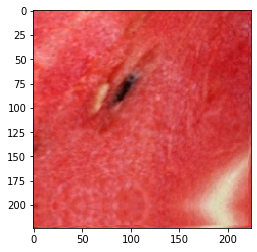

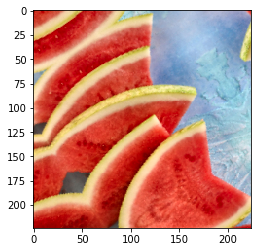

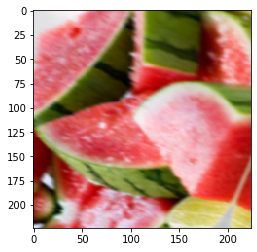

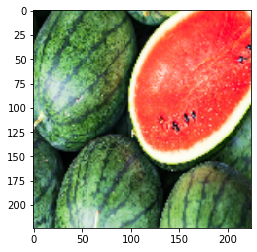

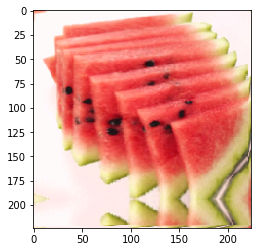

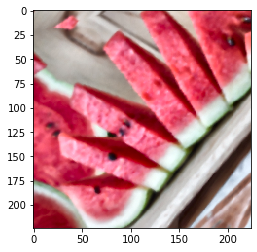

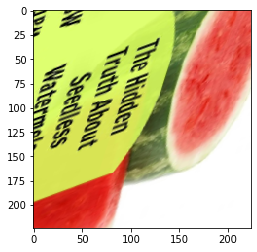

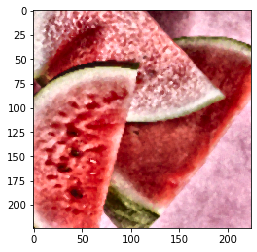

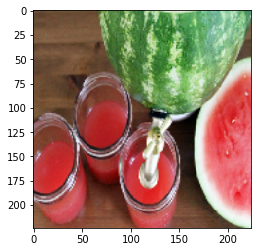

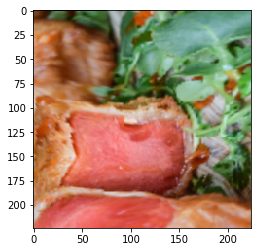

In [7]:
from IPython.display import display # to display images
import matplotlib.pyplot as plt
%matplotlib inline

import random
pairs = train_generator[random.randint(0, len(train_generator))]

for x, y in zip(*pairs):
    plt.figure()
    plt.imshow(to_pil(x, scale_up=True))

    

In [8]:
pairs[1].shape

(10, 121)